"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum

[193 465 605]
[   0  193  465  605 1000]
[0.1901681  0.66312308 0.07654142 0.62151323]


Text(0, 0.5, 'Firing Rate')

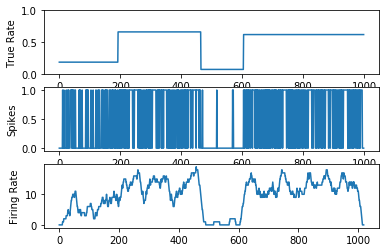

In [57]:
# Some poisson spiking
length = 1000
states = 4
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

true_lambda = np.random.random(states)

print(true_tau)
print(state_inds)
print(true_lambda)

true_r = np.zeros(length)
for num, val in enumerate(true_lambda):
    true_r[state_inds[num]:state_inds[num+1]] = val
  
data_vec = np.random.random(length) < true_r
#data_vec = np.random.poisson(true_r)

fig,ax = plt.subplots(3,1)
ax[0].plot(true_r)
ax[0].set_ylim(0,1)
ax[1].plot(data_vec)
ax[2].plot(np.convolve(data_vec,np.ones(20)))
ax[0].set_ylabel("True Rate")
ax[1].set_ylabel("Spikes")
ax[2].set_ylabel("Firing Rate")

In [58]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [228]:
K = 10

In [229]:
#ordered = pm.distributions.transforms.Ordered()
with pm.Model() as model:
    

    #alpha = pm.Gamma("alpha", 1, 1)
    #beta = pm.Beta("beta", 1.0, alpha, shape=K+1)
    #weights = pm.Deterministic('weights',stick_breaking(beta))
    
    #lambda_pre = pm.Uniform('lambda_pre',0.01,1, shape = K+1)

    a_lambda = 2
    b_lambda = 5
    lambda_latent = pm.Beta('lambda_latent', a_lambda, b_lambda, shape = K+1)
    #lambda_pre = pm.Beta('lambda_pre', a_lambda, b_lambda, shape = K+1)
    #lambda_latent = np.multiply(lambda_pre , weights)
    #lambda_latent = pm.Uniform('lambda_latent',0.01,1, 
    #                           shape = K+1)#, testval = np.linspace(0.1,0.9,K+1))
    
    
    a = pm.HalfCauchy('a_tau', 3.)
    b = pm.HalfCauchy('b_tau', 3.)
    
    #even_switches = np.flip(np.linspace(0,1,K))
    tau_latent = pm.Beta('tau_latent', a, b,
                         shape = K).sort(axis=-1)  
                         #testval = even_switches,
                         
                         
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent) 
    
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((1,length)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)
    
    lambda_ = pm.math.sum(np.multiply(weight_stack,lambda_latent[:,np.newaxis]),axis=0)
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

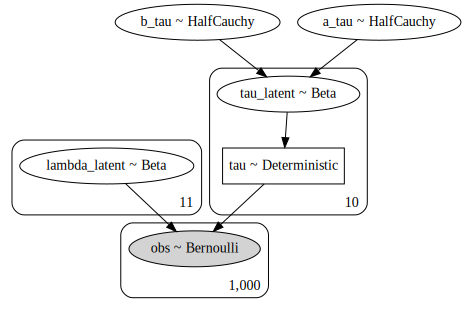

In [230]:
pm.model_to_graphviz(model)

In [231]:
print(tau_latent.tag.test_value)
print(lambda_latent.tag.test_value)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.28571429 0.28571429 0.28571429 0.28571429 0.28571429 0.28571429
 0.28571429 0.28571429 0.28571429 0.28571429 0.28571429]


In [232]:
with model:
    prior_samples = pm.sample_prior_predictive(300)

ValueError: Domain error in arguments.

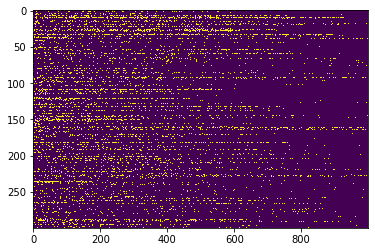

In [233]:
plt.imshow(prior_samples['obs'],aspect='auto');

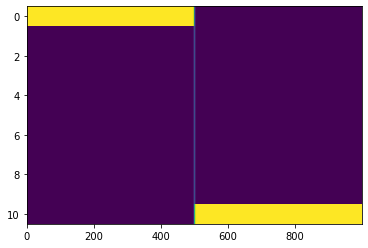

In [234]:
plt.imshow(weight_stack.tag.test_value,aspect='auto');

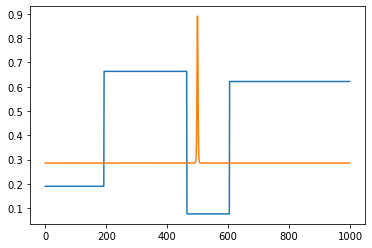

In [235]:
plt.plot(true_r, label = 'True_r');
plt.plot(lambda_.tag.test_value, label = 'Lambda');

In [236]:
with model:
    trace = pm.sample()
#     inference = pm.ADVI('full-rank')
#     approx = pm.fit(n=fit, method=inference,
#                    random_seed = 3,
#                    obj_n_mc = 1)
#     trace = approx.sample(draws=samples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, b_tau, a_tau, lambda_latent]
Sampling 4 chains, 1 divergences: 100%|██████████| 4000/4000 [04:37<00:00, 14.42draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7030221915844447, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6488052791659177, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9092549003879427, but should be close to 0.8. Try to increase the number of tunin

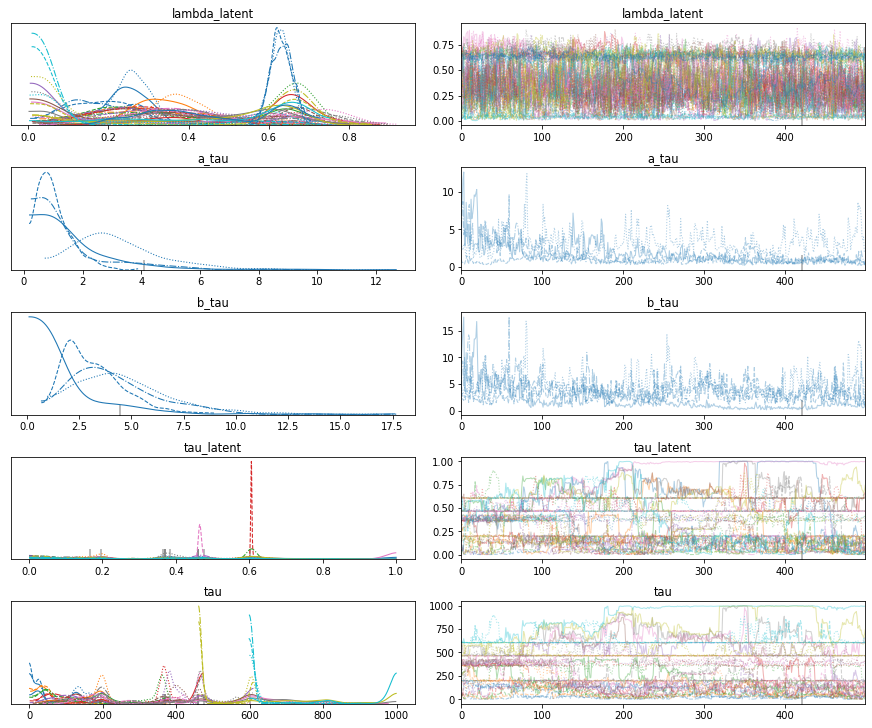

In [237]:
pm.traceplot(trace);

In [238]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

100%|██████████| 2000/2000 [00:01<00:00, 1196.68it/s]


Text(0.5, 1.0, 'Mean prediction')

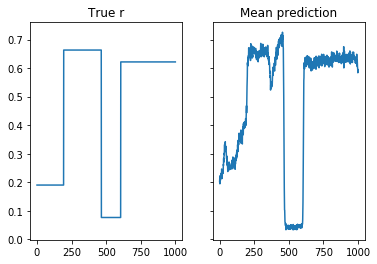

In [239]:
fig,ax = plt.subplots(1,2,sharey=True)
ax[0].plot(true_r)
ax[1].plot(np.mean(ppc['obs'],axis=0), alpha=1)
ax[0].set_title('True r')
ax[1].set_title('Mean prediction')

In [241]:
tau = trace['tau']
#weights = trace['weights']
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
#mode_weights = stats.mode(weights,axis=0)[0][0]

In [242]:
# bin_count = 100
# bins = np.linspace(0,1,50)
# vals = np.array([np.histogram(x, bins = bin_count)[0] for x in weights.T])
# mode_vals = [bins[np.argmax(x)] for x in vals]
# mode_vals

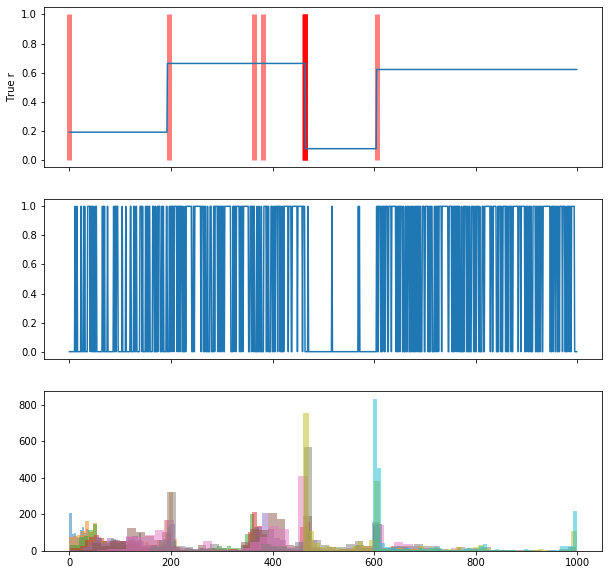

In [243]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(10,10))
ax[0].plot(true_r)
ax[0].set_ylabel('True r')
ax[1].plot(data_vec)
    
for tau_num, this_tau in enumerate(tau.T):
    ax[2].hist(this_tau,bins=50, alpha = 0.5)
    ax[0].vlines(mode_tau[tau_num],0,1,color='red',alpha=0.5,linewidth=5)
